In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os; print(os.getcwd())
import socket; print(socket.gethostname())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/ajasja/projects/truncator
dig79


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from glob import glob
import truncator



In [3]:
#import sys; sys.path.insert(0, "/home/ajasja/projects/Stable_Heterodimers")
#import utils as u

In [4]:
base_dir = "out/R3/12_relooped"
pdb_files = glob(base_dir+"/*/*/*.pdb");
#filter the pdb_layers pdbs and other stuff
pdb_files = [pdb for pdb in pdb_files if "__" in os.path.basename(pdb)]
cut_files = glob("out/R3/01_cut/*/*.pdb");
def print_load_script(row, iloc=None):
    if not iloc is None:
        row = row.ix[iloc]
    full_name = truncator.find_input(row.decoy, pdb_files)
    print(f"cmd.load('{full_name}', format='pdb');")
    cut_name = "__".join(row.decoy.split("__")[:4])
    full_cut_name = truncator.find_input(cut_name, cut_files)
    print(f"cmd.load('{full_cut_name}', format='pdb');")
len(pdb_files)

8

In [5]:
%%time
score_files = sorted(glob(base_dir+"/*/*/*.sc")); print(len(score_files))
sc = truncator.read_score_files_with_cache(score_files,base_dir+"/scores.csv.gzip")
sc = sc.drop_duplicates(keep='last', subset=['decoy']).set_index('decoy', drop=False)
sc['kind']='trunc'


8
CPU times: user 282 ms, sys: 44.4 ms, total: 326 ms
Wall time: 331 ms


In [7]:
list(sc.columns)
name_split=sc.decoy.str.replace('_0001','').str.split("__", expand=True)


sc['base']=name_split[0]
sc['numH']=name_split[1].str.replace('numH','').astype(float)
sc['from']=name_split[2].str.replace('from','').astype(float)
sc['to']=name_split[3].str.replace('to','').astype(float)
sc['cc']=name_split[4].str.replace('cc','')
sc['llr']=name_split[5].str.replace('llr','')
sc['ar1']=name_split[6].str.replace('ar1','').str.split(',', expand=True)[0].astype(int)
sc['ar2']=name_split[7].str.replace('ar2','').str.split(',', expand=True)[0].astype(int)
sc['rms']=name_split[8].str.replace('rms','').astype(float)



In [8]:
gsplit=sc['cc'].str.split('-', expand=True)
gsplit1=gsplit[0].str.len().astype(str)
gsplit2=gsplit[1].str.len().astype(str)
sc['topology']=gsplit1+gsplit2


In [9]:
sc['ar_abs']=abs(sc.ar1)+abs(sc.ar2)

In [10]:
CRYSTAL_STRUCTS = ['ZCON_13', 'ZCON_15', 'ZCON_37', 'ZCON_127', 'ZCON_131']
sc['crystal']=0
sc['base'].str.contains(CRYSTAL_STRUCTS[0])
for name in CRYSTAL_STRUCTS:
    sc['crystal'] = sc['crystal'] + (sc['base']==name)
    sc['crystal'] = sc['crystal'] + sc['base'].str.contains(name+'_')
sc['crystal']= sc['crystal'] > 0

In [11]:
sns.set_style("whitegrid")
sns.set_context("talk")
def plot_hist(field_name, sc=sc):
    g = sns.FacetGrid(sc,  hue="kind", height=6, palette='bright')
    g = (g.map(sns.distplot, field_name, kde=False, norm_hist=False))
    g.add_legend()
    return g

In [12]:
pd.set_option('display.max_colwidth', -1)
q = sc.query("worst9mer<5.0 and psi_pred>0.90 and base=='ZCON_127'").sort_values(by="ar_abs psi_pred worst9mer".split(), 
                                                            ascending=[True, False, True]).groupby('base topology'.split()).head(3)
q['base topology worst9mer worst9mer_helix psi_pred llr ar1 ar2 ar_abs'.split()]

,base,topology,worst9mer,worst9mer_helix,psi_pred,llr,ar1,ar2,ar_abs
decoy,,,,,,,,,
"ZCON_127__numH4.5__from-20.77__to21.47__ccC-DAB__llr5,5__ar10,0__ar20,0__rms0.5",ZCON_127,13,1.515510,0.111212,0.920635,"5,5",0,0,0
"ZCON_127__numH4.5__from-20.77__to21.47__ccC-DAB__llr5,5__ar10,0__ar2-1,-1__rms0.5",ZCON_127,13,1.515510,0.111212,0.920635,"5,5",0,-1,1
"ZCON_127__numH4.5__from-20.77__to21.47__ccC-DAB__llr4,4__ar11,1__ar21,1__rms0.5",ZCON_127,13,1.506781,0.123975,0.960938,"4,4",1,1,2


In [23]:
print_load_script(q, 'ZCON_127__numH4.5__from-20.77__to21.47__ccC-DAB__llr2,5__ar1-1,0__ar2-1,0__rms0.5')

cmd.load('out/R3/11_relooped/ZCON_127/ZCON_127__numH4.5__from-20.77__to21.47__ccC-DAB__llr2,5__ar1-1,0__ar2-1,0__rms0.5/ZCON_127__numH4.5__from-20.77__to21.47__ccC-DAB__llr2,5__ar1-1,0__ar2-1,0__rms0.5.pdb', format='pdb');
cmd.load('out/R3/01_cut/4.5H/ZCON_127__numH4.5__from-20.77__to21.47.pdb', format='pdb');


/home/ajasja/.conda/envs/pyro_scripts/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [36]:
def append_to_picks(row, file_name, iloc=None):
    if not iloc is None:
        row = row.ix[iloc]
    full_name = truncator.find_input(row.decoy, pdb_files)

    with open(file_name, "a+") as myfile:
        myfile.write(full_name+'\n')
    print('added: '+full_name)



In [31]:
for i in range(5):
    print_load_script(q, i)

cmd.load('out/R3/11_relooped/ZCON_13/ZCON_13__numH4.5__from-17.52__to22.91__ccA-DCB__llr2,5__ar1-1,0__ar2-1,0__rms0.5/ZCON_13__numH4.5__from-17.52__to22.91__ccA-DCB__llr2,5__ar1-1,0__ar2-1,0__rms0.5.pdb', format='pdb');
cmd.load('out/R3/01_cut/4.5H/ZCON_13__numH4.5__from-17.52__to22.91.pdb', format='pdb');
cmd.load('out/R3/11_relooped/ZCON_13/ZCON_13__numH4.5__from-17.52__to22.91__ccBC-DA__llr2,5__ar1-2,0__ar2-1,0__rms0.5/ZCON_13__numH4.5__from-17.52__to22.91__ccBC-DA__llr2,5__ar1-2,0__ar2-1,0__rms0.5.pdb', format='pdb');
cmd.load('out/R3/01_cut/4.5H/ZCON_13__numH4.5__from-17.52__to22.91.pdb', format='pdb');
cmd.load('out/R3/11_relooped/ZCON_15_re_loop/ZCON_15_re_loop__numH4.5__from-6.83__to32.93__ccC-BAD__llr2,5__ar1-2,0__ar2-1,0__rms0.5/ZCON_15_re_loop__numH4.5__from-6.83__to32.93__ccC-BAD__llr2,5__ar1-2,0__ar2-1,0__rms0.5.pdb', format='pdb');
cmd.load('out/R3/01_cut/4.5H/ZCON_15_re_loop__numH4.5__from-6.83__to32.93.pdb', format='pdb');
cmd.load('out/R3/11_relooped/ZCON_37/ZCON_37__n

/home/ajasja/.conda/envs/pyro_scripts/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [37]:
append_to_picks(q, "out\R3\For_surface.picks", 0)

added: out/R3/11_relooped/ZCON_13/ZCON_13__numH4.5__from-17.52__to22.91__ccA-DCB__llr2,5__ar1-1,0__ar2-1,0__rms0.5/ZCON_13__numH4.5__from-17.52__to22.91__ccA-DCB__llr2,5__ar1-1,0__ar2-1,0__rms0.5.pdb


/home/ajasja/.conda/envs/pyro_scripts/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:

print_load_script(sc, 'ZCON_37__numH4.5__from-21.21__to22.24__cc[A+B,C+D]__llr2,4__ar10__ar21__rms0.5')

cmd.load('out/R3/04_relooped/ZCON_37/ZCON_37__numH4.5__from-21.21__to22.24__cc[A+B,C+D]__llr2,4__ar10__ar21__rms0.5.pdb', format='pdb');
cmd.load('out/R3/01_cut/4.5H/ZCON_37__numH4.5__from-21.21__to22.24.pdb', format='pdb');


/home/ajasja/.conda/envs/pyro_scripts/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [43]:
q = sc.query("base=='ZCON_37' and gr=='D-ABC' and numH==4.5").sort_values(by="interface_hbonds", ascending=False).head(50)

#plot_hist('interface_hbonds', q)

UndefinedVariableError: name 'gr' is not defined

load out/R3/02_regruped/4.5H/ZCON_37__numH4.5__from-21.21__to22.24__grAB-CD.pdb 


/software/conda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [56]:

print_load_script(q.iloc[0])

load out/R3/02_regruped/3.5H/ZCON_37__numH3.5__from-10.60__to23.42__grA-BCD.pdb 


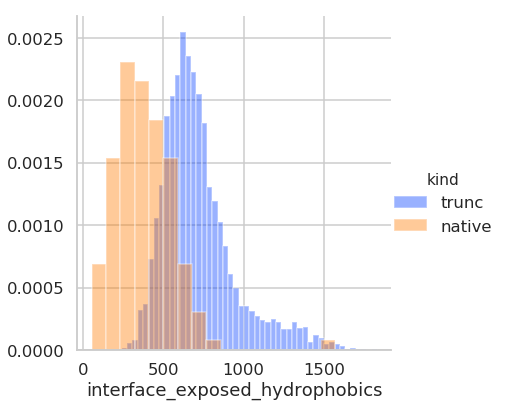

In [106]:
plot_hist('interface_exposed_hydrophobics')
#plt.xlim([-200, 200])

In [8]:
#print("\n".join(list(df.columns)));
cols = truncator.read_file_lines('col_order.list', skip_comments=True)
df = df[cols]


In [9]:
len(df)

6129

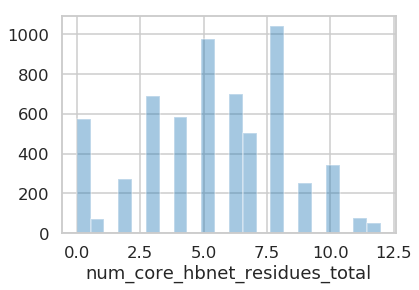

In [16]:

sns.distplot(df['num_core_hbnet_residues_total'].dropna(), kde=False)


In [7]:
logs = sorted(glob("out/01_fuse_to_3chain_14o_7r//*/*/*.sc"))
logs;

In [8]:
%%time
scores = u.load_score_files(logs, load_seq=True)

CPU times: user 1.78 s, sys: 56.4 ms, total: 1.83 s
Wall time: 2.09 s


In [36]:
scores.set_index('description', inplace=True, drop=False)

In [9]:
scores["n_aa"] = scores["seq"].str.len()

KeyError: 'seq'

In [14]:
scores["fa_rep_per_aa"] = scores["fa_rep"]/scores["n_aa"]

In [39]:
scores.to_csv("out/01_fuse_to_3chain_14o_7r.scores")

In [75]:
pd.set_option('display.max_colwidth', -1)
q =scores.sort_values(by='fa_rep').query('fa_rep<400 and sc2>0.5')
print(len(q))
chosen = q
q['total_score fa_rep fa_rep_per_aa clash_check_soft clash_check_hard longest_hpc uhb sc1 sc2 sc1_int_area sc2_int_area full_name'.split()][:10

43


In [76]:
chosen.columns

Index(['total_score', 'ala_count', 'clash_check_hard', 'clash_check_soft',
       'dslf_fa13', 'fa_atr', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi',
       'fa_elec', 'fa_intra_atr_xover4', 'fa_intra_elec',
       'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_rep_fitler',
       'fa_sol', 'gen_bonded', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc',
       'hbond_sr_bb', 'hxl_tors', 'lk_ball', 'lk_ball_bridge',
       'lk_ball_bridge_uncpl', 'lk_ball_iso', 'longest_hpc', 'omega',
       'p_aa_pp', 'pro_close', 'rama_prepro', 'ref', 'sc1', 'sc1_int_area',
       'sc2', 'sc2_int_area', 'ss_count', 'uhb', 'full_name', 'seq', 'n_aa',
       'fa_rep_per_aa', 'description'],
      dtype='object')

In [77]:
import os
def row_to_worms_dict(row):
    d = {}
    d['file'] = os.path.abspath(row.full_name)
    d['name'] = row.description
    d['class'] = ["Het"]
    d['type'] = ["AL_het_C2_N_C"]
    d['base'] = "ZCON37" 
    d['components'] = ["ZCON37", "DHR1", "DHR2"]
    d['validated'] = False
    d['protocol'] =  "Made by Ajasja with H-fuse"
    d['connections'] = [
        {"chain": 1, "direction": "N", "residues":["1:50"]},
        {"chain": 2, "direction": "C", "residues":["-50:"]}
    ]
    return d


In [84]:
def dataframe_to_worms_database(df, out_file=None):
    res = []
    for row in df.itertuples():
        res.append(row_to_worms_dict(row))
    import json
    if out_file is None:
        return json.dumps(res, indent=4)
    with open(out_file, "w") as write_file:
        json.dump(res, write_file, indent=2)
        
dataframe_to_worms_database(chosen, "ALSD01_2018-11-07.database")      

In [45]:

df = pd.DataFrame({'a': np.random.randn(1000), 'b': np.random.randn(1000),'N': np.random.randint(100, 1000, (1000)), 'x': 'x'})

%timeit [row.a * 2 for idx, row in df.iterrows()]
# => 10 loops, best of 3: 50.3 ms per loop

%timeit [row.a * 2 for row in df.itertuples()]
# => 1000 loops, best of 3: 541 µs per loop

188 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.98 ms ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
188/2.98

63.08724832214765